# Deep learning for recognizing Swords and Shields

Note that you have to execute `get_images.ipynb` before running this.

## Hyperparameters

In [1]:
EPOCHS = 100
SHOW_EPOCH_EACH = 10

SAVE_IMAGES_DIR = "data"
HIDDEN_LAYER_COUNT = 50

## Calculate params 

In [2]:
import datetime
from tensorboard.plugins.hparams import api as hp

SWORDS_DATA_COUNT = len(os.listdir("data/sword"))
SHIELDS_DATA_COUNT = len(os.listdir("data/shield"))

DATA_COUNT = SWORDS_DATA_COUNT + SHIELDS_DATA_COUNT

TRAIN_DATA_COUNT = int(DATA_COUNT * 0.8)
TEST_DATA_COUNT = DATA_COUNT - TRAIN_DATA_COUNT

LOG_DIR = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

print(f"Swords data count: {SWORDS_DATA_COUNT}")
print(f"Shields data count: {SHIELDS_DATA_COUNT}")
print(f"train data/test data: {TRAIN_DATA_COUNT}/{TEST_DATA_COUNT}")

Swords data count: 240
Shields data count: 205
train data/test data: 356/89


## Load test cases

In [3]:
import numpy as np
import tensorflow.compat.v2 as tf

# Read a image file and decode it.
def load_from_file(path: str):
    img_content = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_content, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Load all image files in the specific directories and make them a dataset.
def load_all_files(type_name: str, type_num: int):
    save_dir = SAVE_IMAGES_DIR + "/" + type_name

    img_tensors = []
    answer_tensors = []

    for file in os.listdir(save_dir):
        file_path = save_dir + "/" + file
        img_tensor = load_from_file(file_path)
        img_tensors.append(img_tensor)
        answer_tensors.append(tf.one_hot(type_num, 2))

    return img_tensors, answer_tensors

swords_data = load_all_files("sword", 0)
swords_tensor = tf.data.Dataset.from_tensor_slices(swords_data)

shields_data = load_all_files("shield", 1)
shields_tensor = tf.data.Dataset.from_tensor_slices(shields_data)

dataset = swords_tensor.concatenate(shields_tensor).shuffle(DATA_COUNT)

train_dataset = dataset.take(TRAIN_DATA_COUNT).shuffle(DATA_COUNT, reshuffle_each_iteration=True).batch(32)
test_dataset = dataset.skip(TRAIN_DATA_COUNT).shuffle(DATA_COUNT, reshuffle_each_iteration=True).batch(32)


## Check some test cases in the dataset

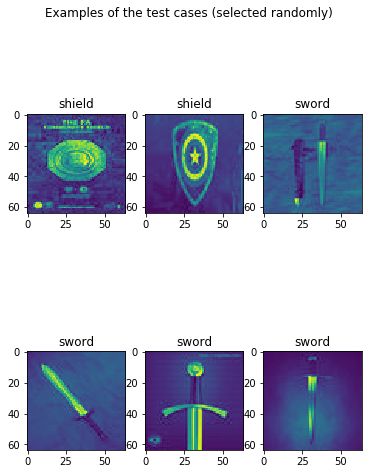

In [4]:
import matplotlib.pyplot as plt

count = 0

fig, axs = plt.subplots(2, 3, figsize=(6, 8))
fig.suptitle('Examples of the test cases (selected randomly)')

for img, ans in train_dataset:
    axs[count // 3, count % 3].set_title("sword" if ans.numpy()[0][0] == 1.0 else "shield")
    axs[count // 3, count % 3].imshow(img[0].numpy().reshape(64, 64))

    count = count + 1
    if count == 6:
        break

fig.show()

## Define a model

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = Conv2D(32, 3, activation="relu")
        self.flatten = Flatten()
        self.d1 = Dense(HIDDEN_LAYER_COUNT, activation="relu")
        self.d2 = Dense(2)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

model = MyModel()

## Initialize optimizer and accuracy calculators

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

train_summary_writer = tf.summary.create_file_writer(LOG_DIR)

## Define a way to train

In [7]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_object(labels, predictions)

    test_loss(loss)
    test_accuracy(labels, predictions)

## Start deep learning! 

In [8]:
for epoch in range(EPOCHS):
    for images, labels in train_dataset:
        train_step(images, labels)

    for test_images, test_labels in test_dataset:
        test_step(test_images, test_labels)

    with train_summary_writer.as_default():
        tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
        tf.summary.scalar('train_accuracy', train_accuracy.result(), step=epoch)
        tf.summary.scalar('test_loss', test_loss.result(), step=epoch)
        tf.summary.scalar('test_accuracy', test_accuracy.result(), step=epoch)
        tf.summary.histogram(f"Layer1 weights", model.d1.weights[0], step=epoch)
        tf.summary.histogram(f"Layer1 bias", model.d1.weights[1], step=epoch)
        tf.summary.histogram(f"Layer2 weights", model.d2.weights[0], step=epoch)
        tf.summary.histogram(f"Layer2 bias", model.d2.weights[1], step=epoch)

    if epoch % SHOW_EPOCH_EACH == SHOW_EPOCH_EACH - 1:
        print(f"----- Epoch : {epoch + 1} -----")
        print(f"Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()}, Test Loss: {test_loss.result()}, Test Accuracy: {test_accuracy.result()}")

    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

model.save(LOG_DIR)

----- Epoch : 10 -----
Loss: 0.150770902633667, Accuracy: 0.9634831547737122, Test Loss: 0.11014655232429504, Test Accuracy: 0.9887640476226807
----- Epoch : 20 -----
Loss: 0.02433689869940281, Accuracy: 0.9971910119056702, Test Loss: 0.045484572649002075, Test Accuracy: 0.9775280952453613
----- Epoch : 30 -----
Loss: 0.013630433939397335, Accuracy: 0.9943820238113403, Test Loss: 0.01356699038296938, Test Accuracy: 1.0
----- Epoch : 40 -----
Loss: 0.004669250920414925, Accuracy: 1.0, Test Loss: 0.00238394970074296, Test Accuracy: 1.0
----- Epoch : 50 -----
Loss: 0.002009970834478736, Accuracy: 1.0, Test Loss: 0.0011951830238103867, Test Accuracy: 1.0
----- Epoch : 60 -----
Loss: 0.0013283147709444165, Accuracy: 1.0, Test Loss: 0.0008262497722171247, Test Accuracy: 1.0
----- Epoch : 70 -----
Loss: 0.0006679384969174862, Accuracy: 1.0, Test Loss: 0.0006149348919279873, Test Accuracy: 1.0
----- Epoch : 80 -----
Loss: 0.0007981686503626406, Accuracy: 1.0, Test Loss: 0.0004076670156791806, 